# Livrable 2 : Classification de photos, de peintures et autres images

Pour ce livrable 2, il nous est demandé de classifier des images données en trois catégories : Photo, Peinture, ou Autre. 
Pour ce faire nous avons suivi plusieurs étapes, en nous basant sur le tutoriel Tensorflow de Google permettant la classification d'image. 
Voici les différentes étapes : 

1. Préparer les données pour le Machine Learning, avec un tri des images potentiellement corrompues
2. Créer notre modèle
3. Entraîner notre modèle et analyser ses résulats 
4. Tester le modèle
5. Améliorer le modèle en fonction des résultats et répéter

## Import de TensorFlow et des autres librairies 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


## Initialisation des variables

In [2]:
batch_size = 32
img_height = 180
img_width = 180
num_classes = 3

Ces deux lignes sont utilisées si l'on fait tourner le code en local et utiliser le GPU pour le faire tourner

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Préparation des données

Ligne utilisée pour vériifer que la carte graphique est correctement détectée 

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Ici on indique juste que nos images sont situées dans le dossier data, situé dans le même répertoire que le Notebook

In [4]:
import pathlib

data_dir = pathlib.Path('data')

On vérifie qu'on a un jeu de données d'environ 40 000 images, moins les images ne possédant pas les bonnes métadata

In [6]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

39726


On peut ainsi afficher quelques images de différentes classes :

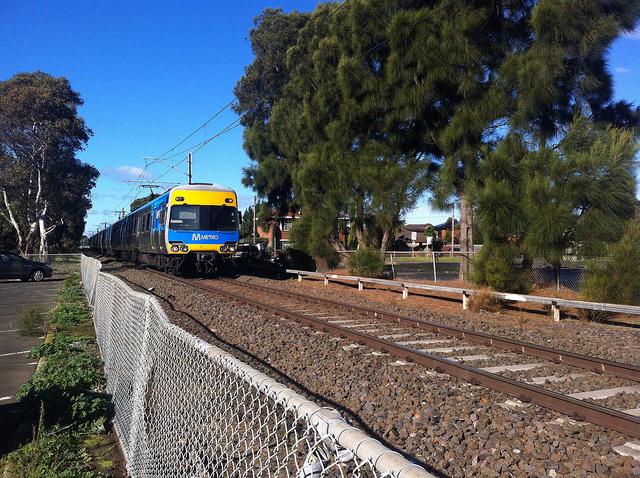

In [ ]:
photos = list(data_dir.glob('Photo/*'))
PIL.Image.open(str(photos[0]))

## Chargement des images à l'aide de keras

On utilise la méthode ``` image_dataset_from_diectory ``` afin de directement créer un dataset d'entraînement et de validation, directement depuis le dossier data contenant toutes nos images



### Création de notre Dataset

On crée donc un dataset d'entraînement et de validation, afin de mesurer l'efficacité de notre modèle. On fournit 80% des données au jeu d'entraînement et 20 % à celui de validation.

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, # Dossier où se trouvent les images
  validation_split=0.2, # On précise que l'on souhaite garder 20% des données pour le dataset de validation, et 80% des données pour le dataset d'entrainement
  subset="training", # On précise ici que c'est le dataset d'entrainement
  seed=123, # Le seed fixe nous permet d'avoir la même répartition de dataset entre entrainement et validation
  image_size=(img_height, img_width), # On utilise la taille des images précisée au début du notebook
  batch_size=batch_size) # On utilise la taille de chaque batch précisée au début du notebook

Found 39726 files belonging to 3 classes.
Using 31781 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation", # On fait la même chose ici, mais pour le dataset de validation
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39726 files belonging to 3 classes.
Using 7945 files for validation.


On peut ensuite retrouver nos 3 classes, Peinture, Photo, et Autre dans les caractéristiques de notre dataset.

In [7]:
class_names = train_ds.class_names
print(class_names)

['Other', 'Painting', 'Photo']


### Configurer le dataset pour être plus performant

On va précharger les données, afin d'éviter des problèmes d'Input Output. On va utiliser :

`Dataset.cache()` va garder les images en mémoire même après la première epoch.

`Dataset.prefetch()` permet de découpler le moment où les données sont produites du moment où les données sont consommées. On peut choisir le nombre d'éléments à précharger ou on peut utiliser `AUTOTUNE` afin de laisser la machine décider.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)





---





# Créer notre modèle <a id='model'></a>

La première couche est une couche de standardisation. Les images étant RGB, les valeurs vont de 0 à 255, ce qui n'est pas optimisé pour un réseau neuronal. On va donc normaliser les données et les faire passer dans l'intervalle `[0, 1]` .


In [9]:

# Partie feature extraction (ou cascade de couches d'extraction des caractéristiques)

model = Sequential([
  # Couche d'entrée:
  # Cette couche prend comme paramètre la forme des images (input_shape), qui est directement redimensionnée avec la taille précédemment définie
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # Partie feature extraction (ou cascade de couches d'extraction des caractéristiques)
  # 1-couche de convolution (conv2D) avec nombre de filtre  (16, puis on double plusieurs fois pour arriver jusqu'à 64), avec le padding 'same', et avec la taille de la fenetre de balayage (kernel size) : 3x3 
  # 2-fonction d'activation ReLU : si input inférieur ou égal à 0, alors sortie = 0, et si input > 0, sortie = input
  # 3-couche d'echantillonage (pooling) pour reduire la taille avec la taille de la fenetre de balayage (pool_size) :2x2  
  layers.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),
  layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2, 2)),

  # Partie complètement connectée (Fully Connected Layer)
  layers.Flatten(), # Flatten: pour convertir les matrices en vecteurs
  layers.Dense(128, activation='relu'), # Dense: une couche neuronale simple avec le nombre de neurone
  layers.Dense(num_classes, activation='softmax') # Puisque'on a une classification multicouche, la dernière couche est ici une fonction d'activation softmax. La sortie sera égale à 1, l'addition des 3 valeurs du vecteur en sortie
])

##  Compilation du modèle


In [10]:
# Compilation du modèle :
# On définit la fonction de perte (SparseCategoricalCrossentropy)
# L'optimisateur utilisé avec ses paramétres (Adam)
# La valeur à afficher durant l'entrainement, metrics=['accuracy'] 
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

On peut vérifier si le modèle est bien construit en vérifiant les couches présentes dans le modèle.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Schéma de l'architecture du réseau de neurones

Schéma de l'architecture du réseau de neurones


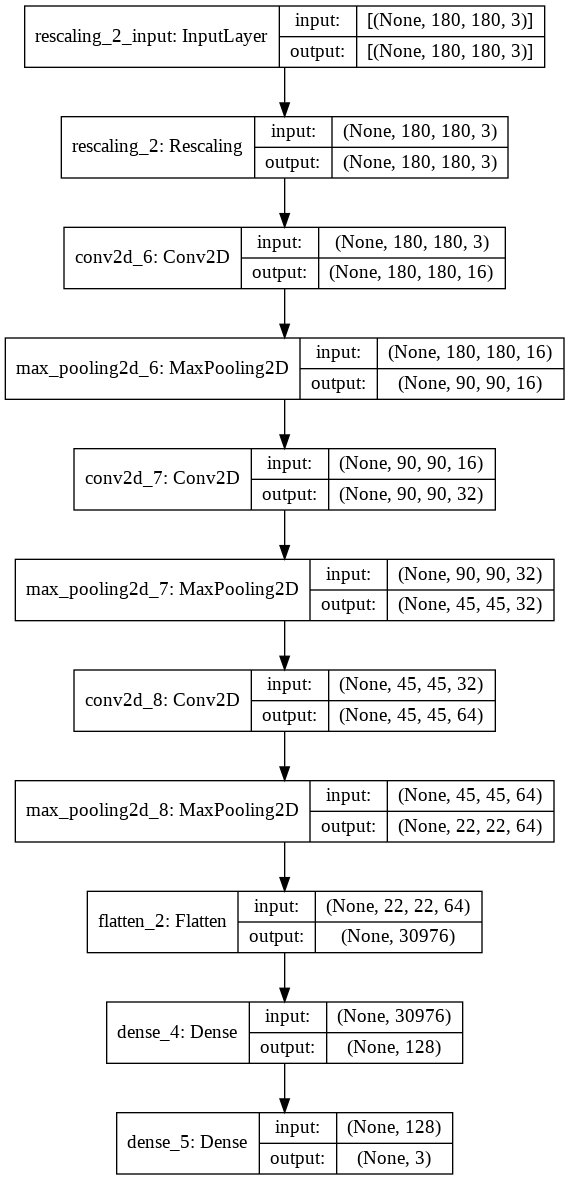

In [20]:
print('Schéma de l\'architecture du réseau de neurones')

keras.utils.plot_model(model, show_shapes=True)

## Entraînement du modèle



On va donc entraîner notre modèle. Comme on va avoir beaucoup d'epoch, on va également mettre en place un système d'arrêt prématuré. En effet, si au bout d'un certain nombre d'epoch sans amélioration sur certains paramètres, on peut décider d'arrêter l'entraînement et ainsi garder seulement le meilleur modèle, avec les meilleurs poids, parmis ceux testés. 

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelsPath = "Basic_Model.hdf5"

# Callback sauvegardant le meilleur modèle
modelcheckpoint = ModelCheckpoint(filepath=modelsPath,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Callback permettant de retourner au meilleur modèle, et d'arrêter l'entrainement plus tôt, si aucune amélioration pendant un nombre d'époques défini
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)


In [13]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[modelcheckpoint, earlystop] # On active nos deux callbacks, qui vont nous permettre de sauvegarder le meilleur modèle possible, et de limiter le nombre d'epochs si jamais aucune amélioration n'est détectée pendant plusieurs epochs
)

Epoch 1/50
336/994 [=========>....................] - ETA: 21s - loss: 0.8624 - accuracy: 0.6971

KeyboardInterrupt: 

## Résultats de l'entraînement

On va afficher un graphique permettant de visualiser l'évolution de notre précision et de notre fonction de perte

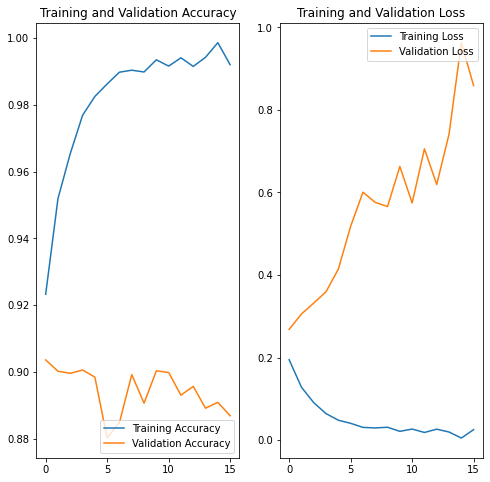

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Sur-entraînement

On peut voir que les courbes se séparent très vite et qu'on observe une faible précision sur le jeu de validation par rapport au jeu de test. 
De même, la perte sur le jeu de validation augmente très fortement, quand celle sur le jeu de test faiblit. On voit qu'on a un sur-apprentissage évident, car sur notre jeu de test, notre algorithme est de plus en plus performant, mais sur notre jeu de validation, sa précision baisse drastiquement. 

## Augmentation du nombre de données

Afin d'éviter le surentraînement, on va tenter de fournir à notre modèle plus de données. Pour cela on va simplement appliquer différentes opérations sur les images comme une rotation, ou un zoom. 

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

## Dropout

On peut aussi également utiliser le dropout. Le dropout consiste à désactiver des neurones de façon aléatoire, selon un certain pourcentage, comme 10, 20, 30.Cela veut dire que 10, 20 ou 30% des valeurs de sortie vont être ignorées par la couche suivante. 
Le Dropout va donc permettre au modèle de ne pas se reposer toujours sur les mêmes neurones, car en désactivant de façon aléatoire certains neurones, de nouvelles connexions doivent être explorées par le modèle, pouvant ainsi possiblement améliorer sa précision. 

On a donc modifié notre modèle afin d'ajouter le dropout et la data augmentation. 


In [15]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

## Recompilation du modèle et entraînement

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Schéma de l'architecture du réseau de neurones <a id='archi'></a>

Schéma de l'architecture du réseau de neurones


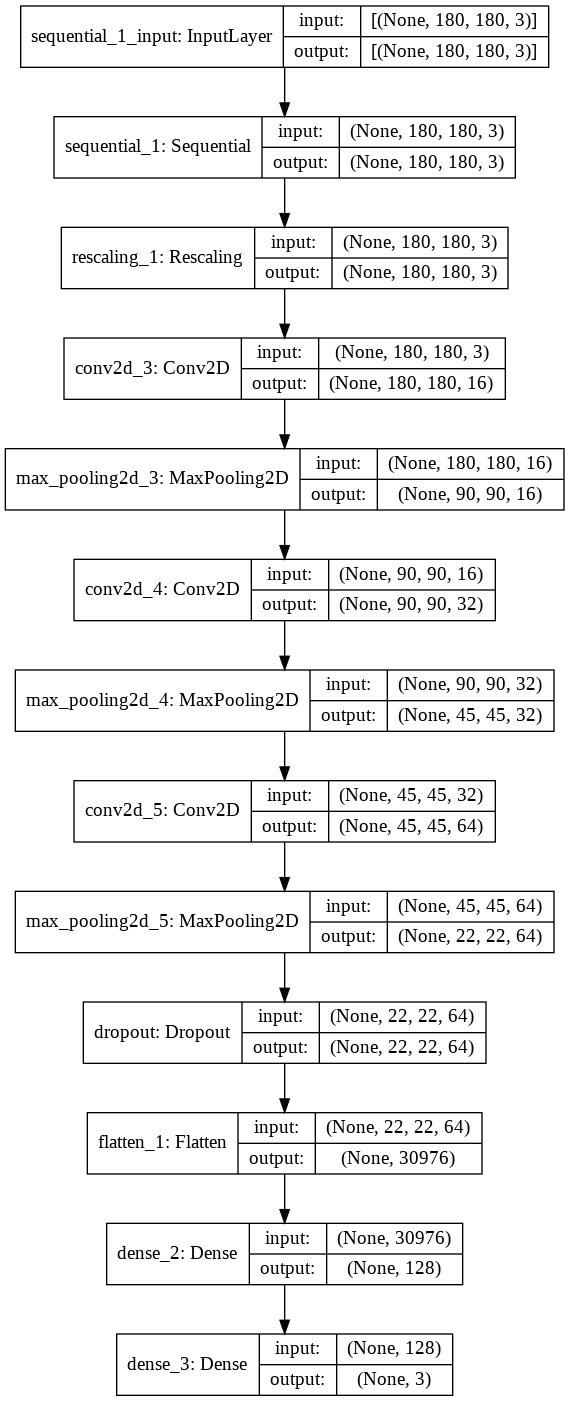

In [15]:
print('Schéma de l\'architecture du réseau de neurones')

keras.utils.plot_model(model, show_shapes=True)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelsPath_dropout = "Basic_Model_Dropout.hdf5"

modelcheckpoint_dropout = ModelCheckpoint(filepath=modelsPath_dropout,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Callback permettant de retourner au meilleur modèle, et d'arrêter l'entrainement plus tôt, si aucune amélioration pendant un nombre d'époques défini
earlystop_dropout = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)


epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[modelcheckpoint_dropout, earlystop_dropout]
)

Epoch 1/50
994/994 [==============================] - 89s 88ms/step - loss: 0.6397 - accuracy: 0.7279 - val_loss: 0.3918 - val_accuracy: 0.8386

Epoch 00001: val_accuracy improved from -inf to 0.83864, saving model to Basic_Model_Dropout.hdf5
Epoch 2/50
994/994 [==============================] - 60s 60ms/step - loss: 0.3873 - accuracy: 0.8365 - val_loss: 0.3386 - val_accuracy: 0.8613

Epoch 00002: val_accuracy improved from 0.83864 to 0.86130, saving model to Basic_Model_Dropout.hdf5
Epoch 3/50
994/994 [==============================] - 68s 68ms/step - loss: 0.3315 - accuracy: 0.8622 - val_loss: 0.3253 - val_accuracy: 0.8672

Epoch 00003: val_accuracy improved from 0.86130 to 0.86721, saving model to Basic_Model_Dropout.hdf5
Epoch 4/50
994/994 [==============================] - 62s 63ms/step - loss: 0.3018 - accuracy: 0.8767 - val_loss: 0.3883 - val_accuracy: 0.8373

Epoch 00004: val_accuracy did not improve from 0.86721
Epoch 5/50
994/994 [==============================] - 61s 61ms/st

## Résultats de l'entraînement <a id='graph'></a>

Après avoir appliqué l'augmentation des données, ainsi que du dropout on peut observer que les courbes sont plus proches et mieux alignées. 

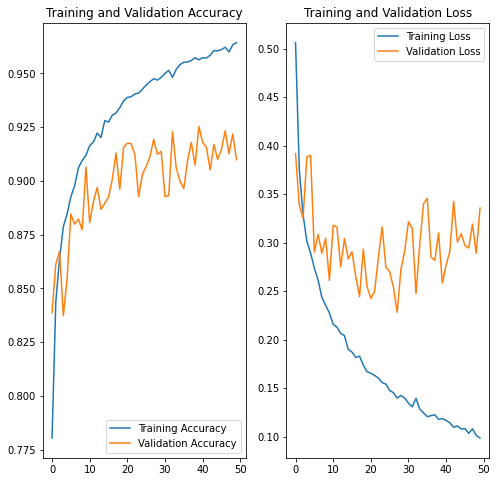

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Test de la précision des modèles




### Test du modèle non retenu







Durant notre travail nous avons testé plusieurs modèles, qui nous ont donné des résultats plus ou moins satisfaisant. Nous les avons bien entendu enregistrés afin de pouvoir comparer leur efficacité avec notre modèle actuel, qui est celui proposé par Google, dans son tutoriel de classification d'images. 



Ce modèle en question possède plus de couches, et possède une `val_accuracy` accrue. Cependant, lors de tests sur plusieurs photographies du dataset COCO, il se révèle légèrement moins performant que le premier modèle.

In [ ]:
import pandas as pd
final = pd.DataFrame(columns=['correct', 'score', 'filename'])

folder_path = "test"
i = 0
for fname in os.listdir(folder_path):
    if i == 1000:
        break
    fpath = os.path.join(folder_path, fname)
    img = keras.preprocessing.image.load_img('test/'+fname, target_size=(img_height, img_width))           
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    score = predictions[0]
    if(class_names[np.argmax(score)] == "Photo"):
        final = final.append({'correct':True, 'score':100 * np.max(score), 'filename':fname}, ignore_index=True)
    else:
        final = final.append({'correct':False, 'score':100 * np.max(score), 'filename':fname}, ignore_index=True)
    i = i + 1

In [26]:
average = final_2['score'].sum() / 1000
print("Précison moyenne: ", average)
correct = 100 * final_2['correct'].sum() / 1000  
print("Pourcentage de prédictions correctes: ", correct)

Précison moyenne:  90.12470094561577
Pourcentage de prédictions correctes:  84.4


### Test du modèle retenu





Le modèle que nous avons retenu possède moins de couches, et se révèle légèrement plus performant que le premier modèle testé. Il s'agit de celui qui est détaillé tout au long de ce notebook, et qui possèdes des douches de Data Augmentation ainsi que du dropout

In [14]:
import pandas as pd
othermodel = tf.keras.models.load_model("Model_pixel_without_da.hdf5")

# Pour rappel, nous ré-affichons la description d'un autre modèle que nous avons conçu et testé

           


final_2 = pd.DataFrame(columns=['correct', 'score', 'filename'])

folder_path = "test"
i = 0

img = keras.preprocessing.image.load_img('test/COCO_test2014_000000000155.jpg', target_size=(img_height, img_width))           
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = othermodel.predict(img_array)
score = predictions
print(predictions)
class_names = ['Other', 'Painting', 'Photo']
print(class_names[np.argmax(predictions[0])])

[[0.09719975 0.4129434  0.4898568 ]]
Photo


In [30]:
average = final['score'].sum() / 1000

print("Précison moyenne: ", average)

correct = 100 * final['correct'].sum() / 1000  

print("Pourcentage de prédictions correctes: ", correct)

Précison moyenne:  89.30805568099022
Pourcentage de prédictions correctes:  85.7


Nous avons donc sélectionné ce modèle, dont voici les caractéristiques :

- Optimiseur Adam (extension de la descente de gradient stochastique), qui se révèle être plus performant que les autres optimiseurs testés (dont un exemple est visible plus bas)

- La fonction de perte `SparseCategoricalCrossentropy`, qui permet de ressortir la prédiction la plus probable de notre modèle, contrairement à d'autres fonctions comme `CategoricalCrossentropy` qui auraient ressorti l'ensemble des probabilités

- Les paramètres du réseau sont expliqués lors de la [création du modèle](#model) 

- Une `val_accuracy` de 0.91265

- Une précision moyenne sur 1000 photos issues du dataset COCO de 89.30%

- Un pourcentage de prédictions correctes sur 1000 photos issues du même dataset de 85.7%

On peut donc voir [ici](#archi) un schéma de l'architecture de notre réseau de neurones, et [ici](#graph) les graphiques retraçant l'évolution de la perte et de la précision de notre modèle au fur et à mesure des epoch

## Autres tests non concluants



 ### Batch norm

In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelsPath_dropout = "Basic_Model_BatchNorm.hdf5"

modelcheckpoint_dropout = ModelCheckpoint(filepath=modelsPath_dropout,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Callback permettant de retourner au meilleur modèle, et d'arrêter l'entrainement plus tôt, si aucune amélioration pendant un nombre d'époques défini
earlystop_dropout = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)


epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[modelcheckpoint_dropout, earlystop_dropout]
)

Epoch 1/20
994/994 [==============================] - 48s 48ms/step - loss: 0.5711 - accuracy: 0.7477 - val_loss: 0.5201 - val_accuracy: 0.7957

Epoch 00001: val_accuracy improved from -inf to 0.79572, saving model to Basic_Model_BatchNorm.hdf5
Epoch 2/20
994/994 [==============================] - 44s 44ms/step - loss: 0.3897 - accuracy: 0.8359 - val_loss: 0.4159 - val_accuracy: 0.8361

Epoch 00002: val_accuracy improved from 0.79572 to 0.83612, saving model to Basic_Model_BatchNorm.hdf5
Epoch 3/20
994/994 [==============================] - 47s 47ms/step - loss: 0.3580 - accuracy: 0.8534 - val_loss: 0.4544 - val_accuracy: 0.8028

Epoch 00003: val_accuracy did not improve from 0.83612
Epoch 4/20
994/994 [==============================] - 33s 34ms/step - loss: 0.3333 - accuracy: 0.8656 - val_loss: 0.4433 - val_accuracy: 0.8351

Epoch 00004: val_accuracy did not improve from 0.83612
Epoch 5/20
994/994 [==============================] - 42s 43ms/step - loss: 0.3322 - accuracy: 0.8651 - val

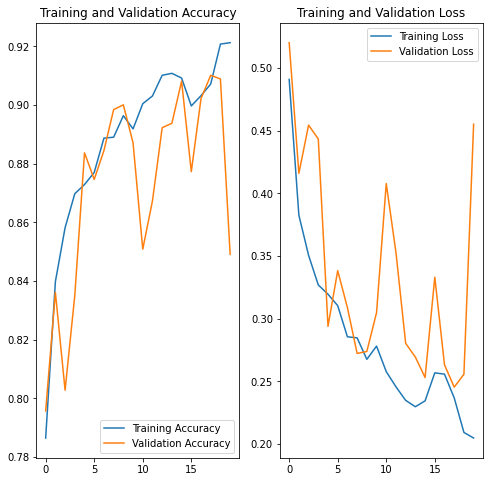

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Adamax



In [ ]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adamax(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
modelsPath_dropout = "Basic_Model_alternateopt.hdf5"

modelcheckpoint_dropout = ModelCheckpoint(filepath=modelsPath_dropout,
                                  monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Callback permettant de retourner au meilleur modèle, et d'arrêter l'entrainement plus tôt, si aucune amélioration pendant un nombre d'époques défini
earlystop_dropout = EarlyStopping(monitor = 'val_accuracy',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)


epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[modelcheckpoint_dropout, earlystop_dropout]
)

Epoch 1/20
994/994 [==============================] - 30s 27ms/step - loss: 0.2297 - accuracy: 0.9104 - val_loss: 0.3210 - val_accuracy: 0.8998

Epoch 00001: val_accuracy improved from -inf to 0.89981, saving model to Basic_Model_alternateopt.hdf5
Epoch 2/20
994/994 [==============================] - 56s 56ms/step - loss: 0.2262 - accuracy: 0.9149 - val_loss: 0.3307 - val_accuracy: 0.9001

Epoch 00002: val_accuracy improved from 0.89981 to 0.90006, saving model to Basic_Model_alternateopt.hdf5
Epoch 3/20
994/994 [==============================] - 17s 17ms/step - loss: 0.2229 - accuracy: 0.9137 - val_loss: 0.3039 - val_accuracy: 0.9041

Epoch 00003: val_accuracy improved from 0.90006 to 0.90409, saving model to Basic_Model_alternateopt.hdf5
Epoch 4/20
994/994 [==============================] - 27s 27ms/step - loss: 0.2241 - accuracy: 0.9153 - val_loss: 0.3151 - val_accuracy: 0.8991

Epoch 00004: val_accuracy did not improve from 0.90409
Epoch 5/20
994/994 [==============================

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()